<a href="https://colab.research.google.com/github/Manish22332/my_projects/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Download the dataset of dogs and cats from kaggle

In [ ]:
!wget https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip

--2020-08-15 07:01:41--  https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.kaggle.com/account/login?ReturnUrl=%2Fc%2Fdogs-vs-cats-redux-kernels-edition%2Fdownload%2Ftrain.zip [following]
--2020-08-15 07:01:41--  https://www.kaggle.com/account/login?ReturnUrl=%2Fc%2Fdogs-vs-cats-redux-kernels-edition%2Fdownload%2Ftrain.zip
Reusing existing connection to www.kaggle.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘train.zip.1’

train.zip.1             [ <=>                ]   9.21K  --.-KB/s    in 0.05s   

2020-08-15 07:01:42 (189 KB/s) - ‘train.zip.1’ saved [9430]



Unzip the dataset and move it in two different folders 

In [ ]:
%cd content/gdrive/My Drive/colab_dataset/

/content/gdrive/My Drive/colab_dataset


In [ ]:
%cd train

/content/gdrive/My Drive/colab_dataset/data/train


In [ ]:
!unzip train.zip
%mv train data
%cd data
%mkdir train val
%mkdir train/cat train/dog
%mkdir val/cat val/dog

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      
  inflating: train/dog.5521.jpg      
  inflating: train/dog.5522.jpg      

In [ ]:
%mkdir training val
%mkdir training/cat training/dog
%mkdir val/cat val/dog

In [ ]:
%ls | grep cat | sort -R | head -250 | xargs -I {} mv {} training/cat/
%ls | grep dog | sort -R | head -250 | xargs -I {} mv {} training/dog/
%ls | grep cat | sort -R | head -250 | xargs -I {} mv {} val/cat/
%ls | grep dog | sort -R | head -250 | xargs -I {} mv {} val/dog/

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math

In [ ]:
TRAIN_DATA_DIR = 'training/'
VALIDATION_DATA_DIR = 'val/'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
def model_maker():
    base_model = MobileNet(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [ ]:
model = model_maker()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

17227776/17225924 [==============================] - 1s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
8/8 [==============================] - 40s 5s/step - loss: 0.6024 - acc: 0.7340 - val_loss: 0.1456 - val_acc: 0.9500
Epoch 2/10
8/8 [==============================] - 39s 5s/step - loss: 0.1180 - acc: 0.9480 - val_loss: 0.0837 - val_acc: 0.9680
Epoch 4/10
8/8 [==============================] - 39s 5s/step - loss: 0.0858 - acc: 0.9760 - val_loss: 0.0740 - val_acc: 0.9720
Epoch 5/10
8/8 [==============================] - 39s 5s/step - loss: 0.0928 - acc: 0.9660 - val_loss: 0.0828 - val_acc: 0.9740
Epoch 6/10
8/8 [==============================] - 39s 5s/step - loss: 0.0611 - acc: 0.9700 - val_loss: 0.0723 - val_acc: 0.9740
Epoch 7/10
8/8 [==============================] - 39s 5s/step - loss: 0.0554 - acc: 0.9780 - val_loss: 0.0659 - val_acc: 0.9740
Epoch 8/10
8/8 [==============================] - 43s 5s/step - loss: 0.0518 - acc: 0.9800 

In [ ]:
%ls

data/  model.h5  train.zip


In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
model = load_model('model.h5')

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
VALIDATION_DATA_DIR = 'data/train/val/'
VALIDATION_BATCH_SIZE = 64

In [ ]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=VALIDATION_BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 500 images belonging to 2 classes.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope(
    {'GlorotUniform': glorot_uniform()}):
    model = load_model('model.h5')

In [ ]:
filenames = validation_generator.filenames
print(len(filenames))
print(filenames[:10])

500
['cat/cat.10032.jpg', 'cat/cat.10089.jpg', 'cat/cat.10202.jpg', 'cat/cat.10228.jpg', 'cat/cat.10290.jpg', 'cat/cat.1045.jpg', 'cat/cat.1046.jpg', 'cat/cat.10468.jpg', 'cat/cat.10469.jpg', 'cat/cat.10541.jpg']


In [ ]:
actual_class = validation_generator.classes
label_to_index = validation_generator.class_indices
print(label_to_index)
index_to_label = dict((v, k) for k, v in label_to_index.items())
print(index_to_label)

{'cat': 0, 'dog': 1}
{0: 'cat', 1: 'dog'}


In [ ]:
predictions = model.predict(validation_generator, steps=None)
prediction_index = []
for prediction in predictions:
    prediction_index.append(np.argmax(prediction))

In [ ]:
def accuracy(predictions, ground_truth):
    total = 0
    for i, j in zip(predictions, ground_truth):
        if i == j:
            total += 1
    return total * 1.0 / len(predictions)
print(accuracy(prediction_index, actual_class))

0.978


In [ ]:
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [
        value_of_highest_probability, index_of_highest_probability,
        ground_truth[index]
    ]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [ ]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

In [ ]:
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

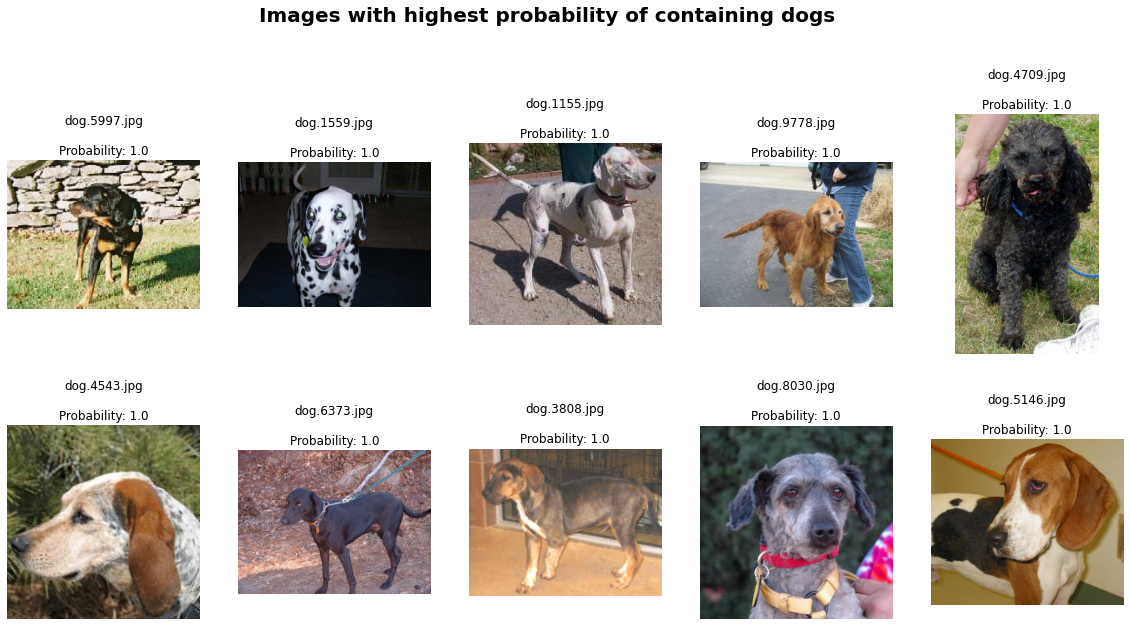

In [ ]:
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10, False)
message = 'Images with highest probability of containing dogs'
display(most_confident_dog_images, message)

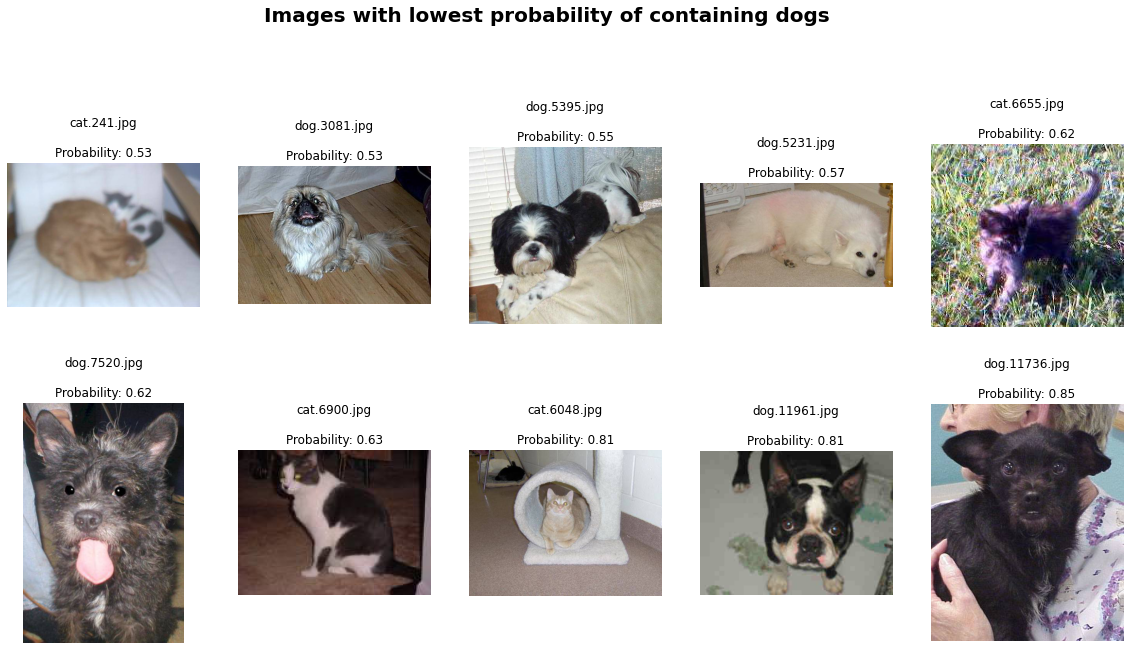

In [ ]:
least_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, False, 1, 10, False)
message = 'Images with lowest probability of containing dogs'
display(least_confident_dog_images, message)

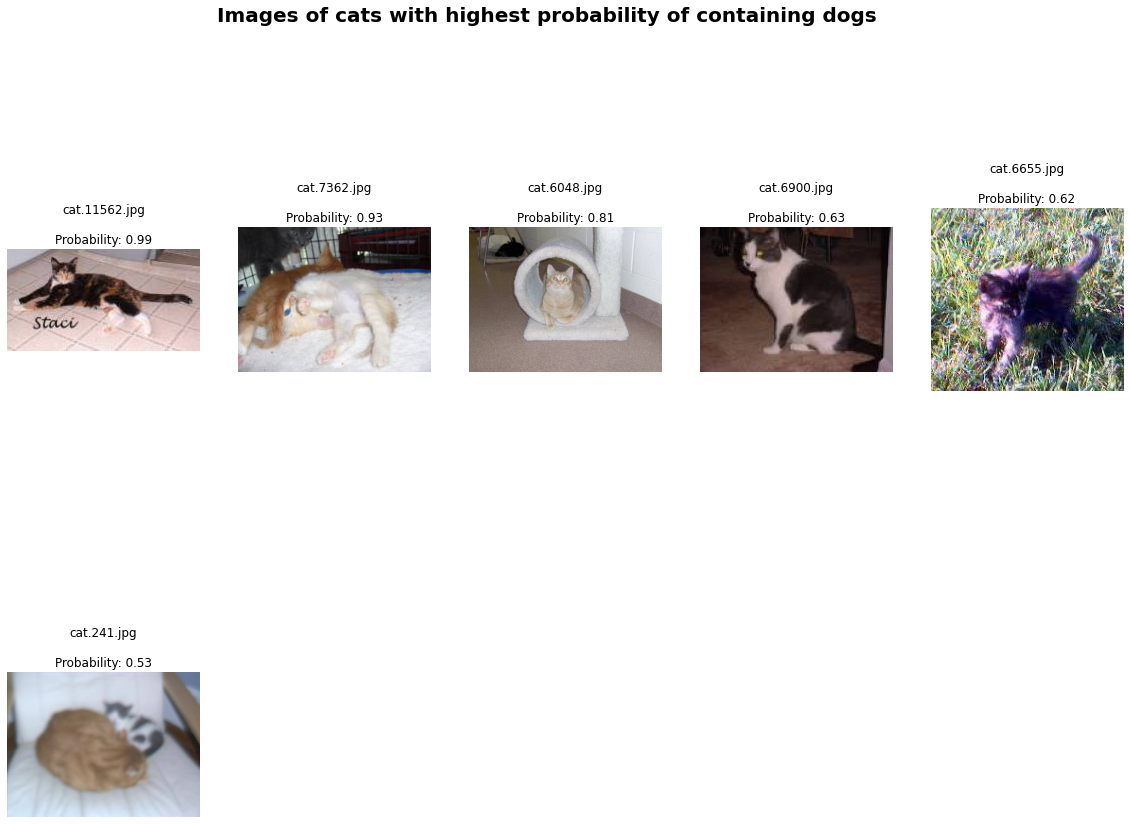

In [ ]:
incorrect_dog_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10,
                                               True)
message = 'Images of cats with highest probability of containing dogs'
display(incorrect_dog_images, message)

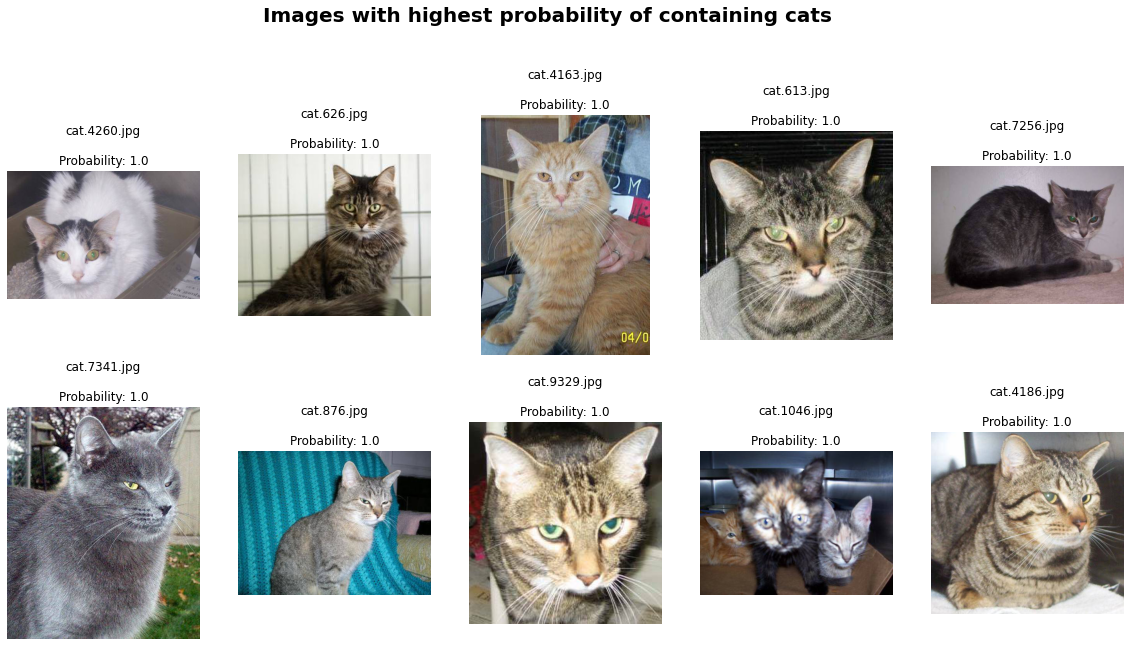

In [ ]:
most_confident_cat_images = get_images_with_sorted_probabilities(prediction_table, True, 0, 10,
                                               False)
message = 'Images with highest probability of containing cats'
display(most_confident_cat_images, message)

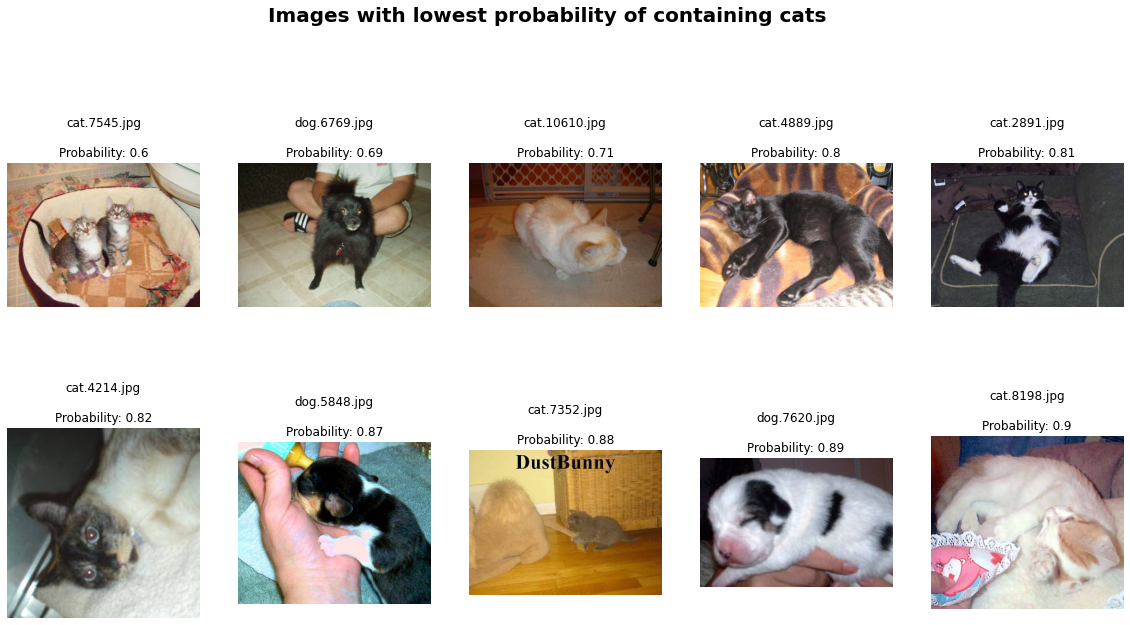

In [ ]:
least_confident_cat_images = get_images_with_sorted_probabilities(prediction_table, False, 0, 10,
                                               False)
message = 'Images with lowest probability of containing cats'
display(least_confident_cat_images, message)

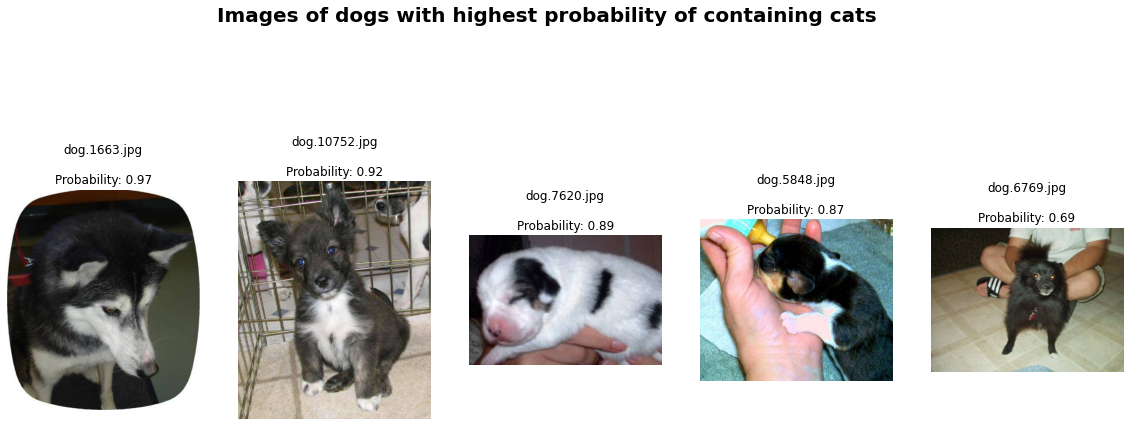

In [ ]:
incorrect_cat_images = get_images_with_sorted_probabilities(prediction_table, True, 0, 10,
                                               True)
message = 'Images of dogs with highest probability of containing cats'
display(incorrect_cat_images, message)